## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, root_mean_squared_error

In [2]:
#random seed for reproducibility
RANDOM_SEED = 42

In [3]:
data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')
weather = pd.read_csv('../data/weather_2018.csv')

In [4]:
weather_cols = ["datetime","temp","feelslike","dew","humidity","precip","precipprob","snow","snowdepth","windgust","windspeed","sealevelpressure","visibility"]

In [5]:
weather_cleaned = weather[weather_cols]
weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])

#backfill missing weather data
weather_cleaned = weather_cleaned.sort_values('datetime').set_index('datetime').asfreq('h')
weather_cleaned = weather_cleaned.fillna(method='ffill')
weather_cleaned = weather_cleaned.reset_index()
weather_cleaned["day_of_week"] = weather_cleaned["datetime"].dt.dayofweek
weather_cleaned["hour_of_day"] = weather_cleaned["datetime"].dt.hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_14742/1873952036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_14742/1873952036.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_cleaned = weather_cleaned.fillna(method='ffill')


In [6]:
stations.groupby('station_id').size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(5)

station_id  counts
268       530.0       2
0          72.0       1
570      3388.0       1
560      3376.0       1
561      3377.0       1

It looks like there is a station id with different latitude and longitude. The 5th value differs, therefore we shorten it. 

In [7]:
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)
stations = stations.drop_duplicates(subset=['station_id', 'station_latitude', 'station_longitude'])

In [8]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848 entries, 0 to 848
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         848 non-null    float64
 1   station_latitude   848 non-null    float64
 2   station_longitude  848 non-null    float64
 3   category           848 non-null    object 
dtypes: float64(3), object(1)
memory usage: 33.1+ KB


Text(0, 0.5, 'Latitude')

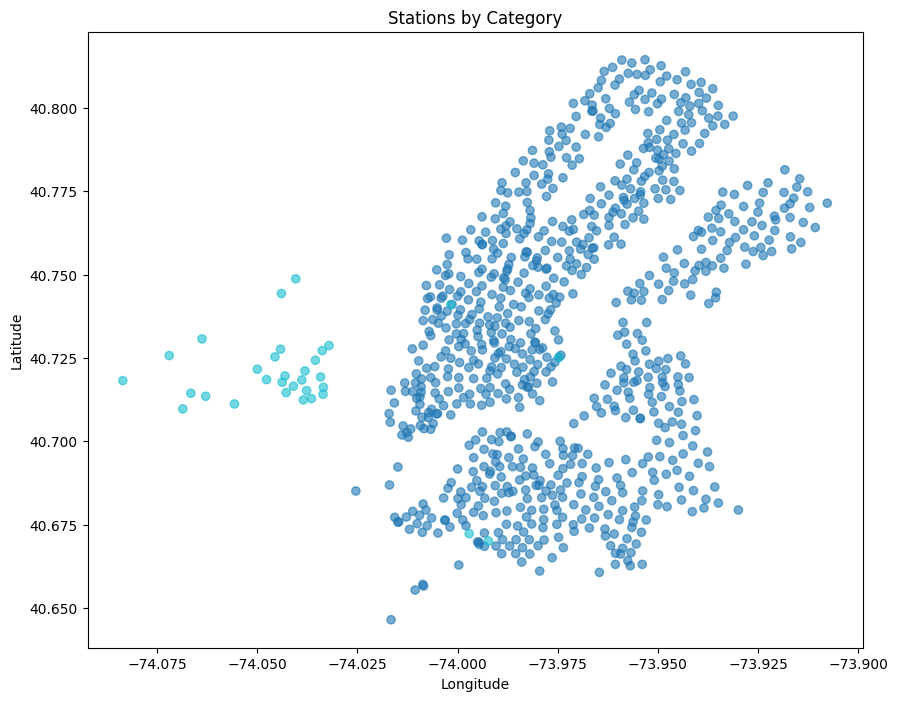

In [9]:
categories = stations['category'].astype('category')
colors = categories.cat.codes  
fig = plt.figure(figsize=(10, 8))
plt.scatter(
    stations['station_longitude'],
    stations['station_latitude'],
    c=colors,
    cmap='tab10',     
    alpha=0.6
)

plt.title('Stations by Category')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


## Clustering

In [10]:
def plot_station_clusters(df):
    n_clusters = len(set(df["station_cluster"]))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, x='station_longitude', y='station_latitude', hue='station_cluster', palette='tab20', ax=ax)
    ax.set_title(f'Station Clusters (n={n_clusters})')

def elbow_method(data, max_k):
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 31), sse, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Sum of squared distances')
    plt.xticks(range(1, 31))
    plt.show()

def silloute_score_plot(data, max_k):
    scores = []
    for k in range(20, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)
        scores.append(score)
    plt.figure(figsize=(10, 6))
    plt.plot(range(20, max_k + 1), scores, marker='o')
    plt.title('Silhouette Score For Optimal k')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(20, max_k + 1))
    plt.show()   

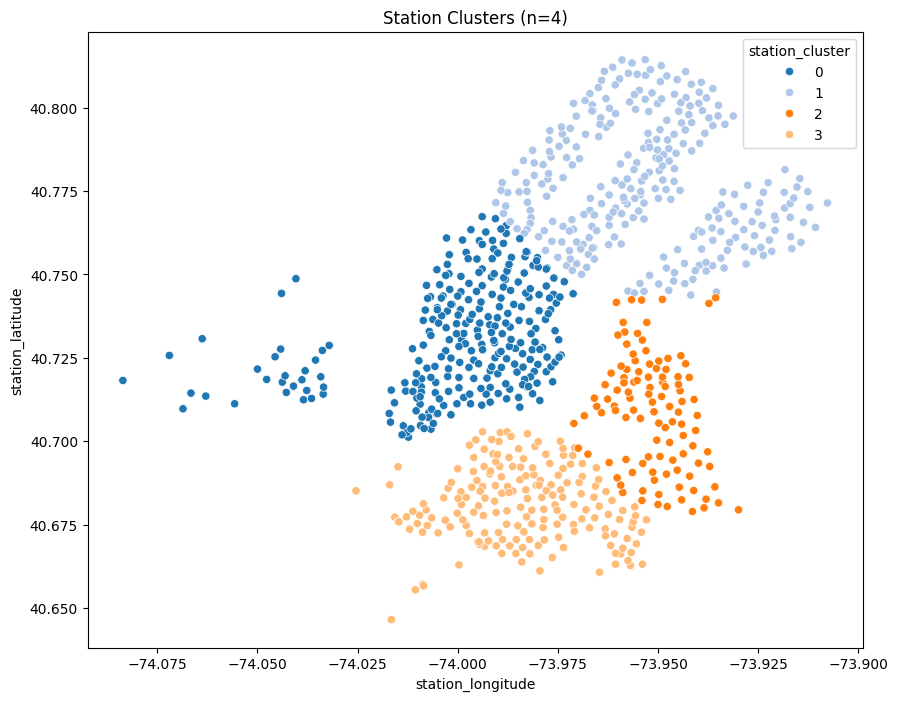

In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_
plot_station_clusters(stations)

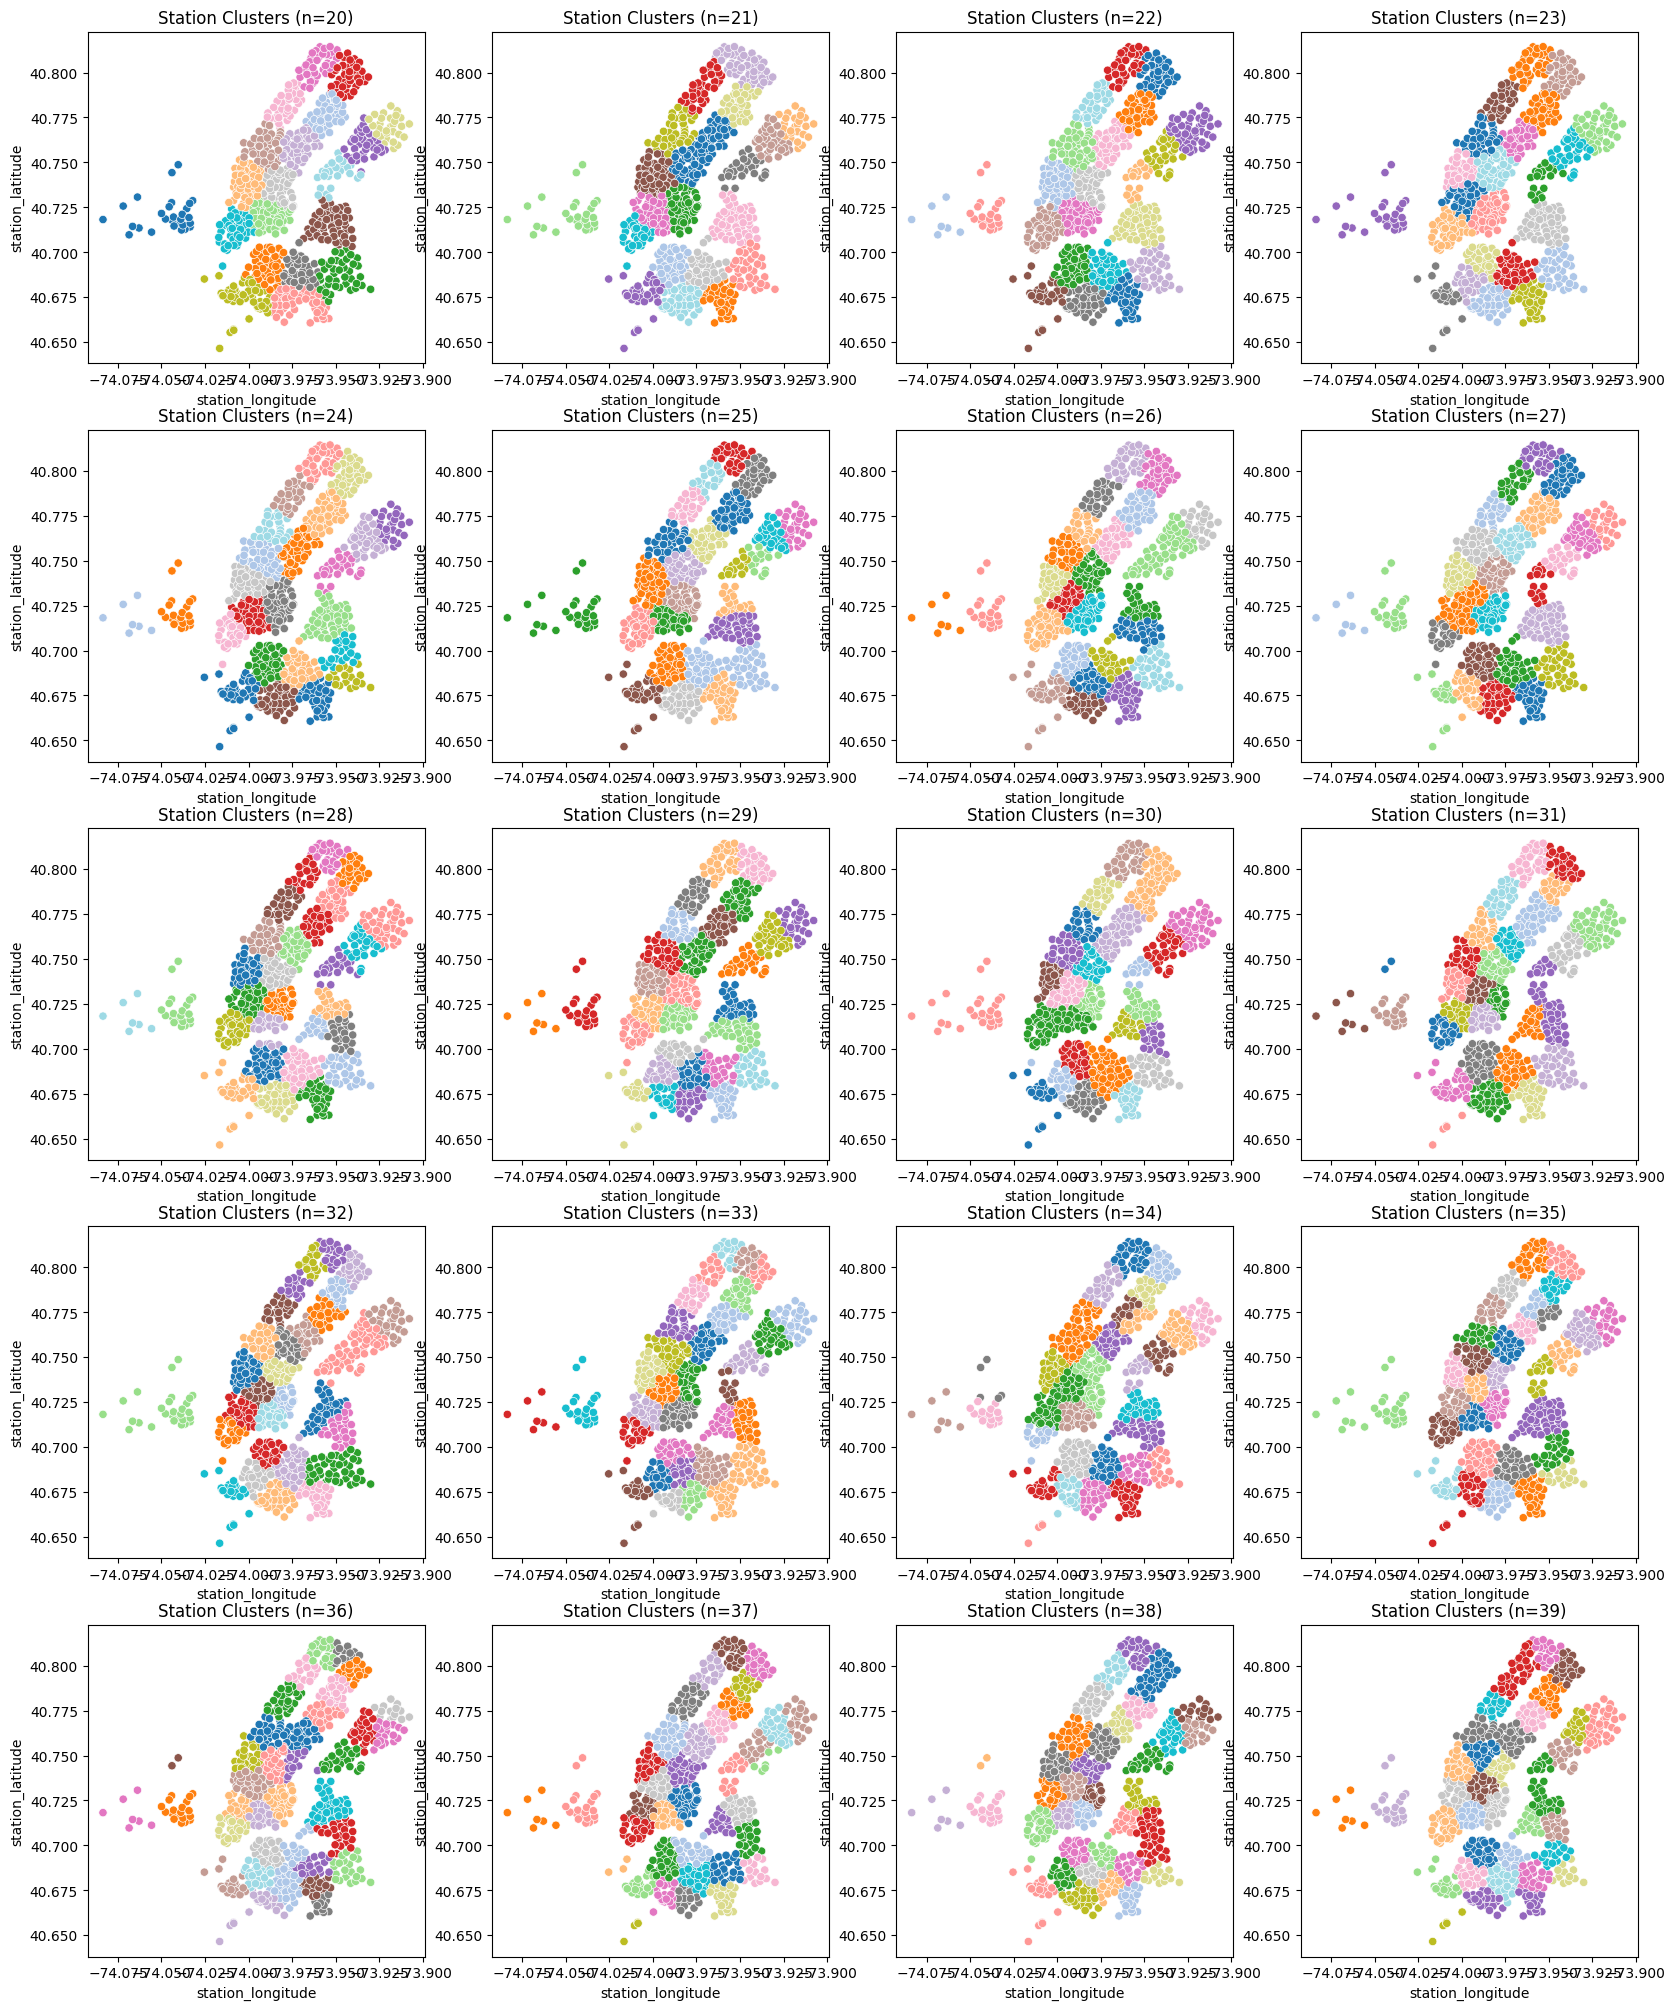

In [12]:
# plot k means for up to 20 clusters
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    kmeans = KMeans(n_clusters=n_clusters+19)
    kmeans.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = kmeans.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+19})')

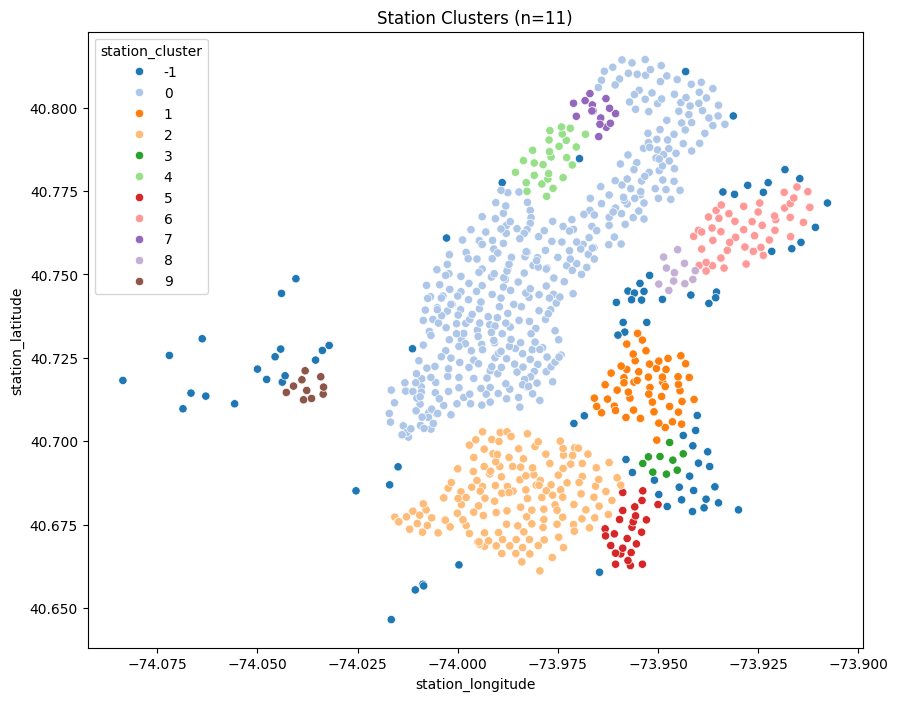

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.006, min_samples=10)
dbscan.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = dbscan.labels_
plot_station_clusters(stations)

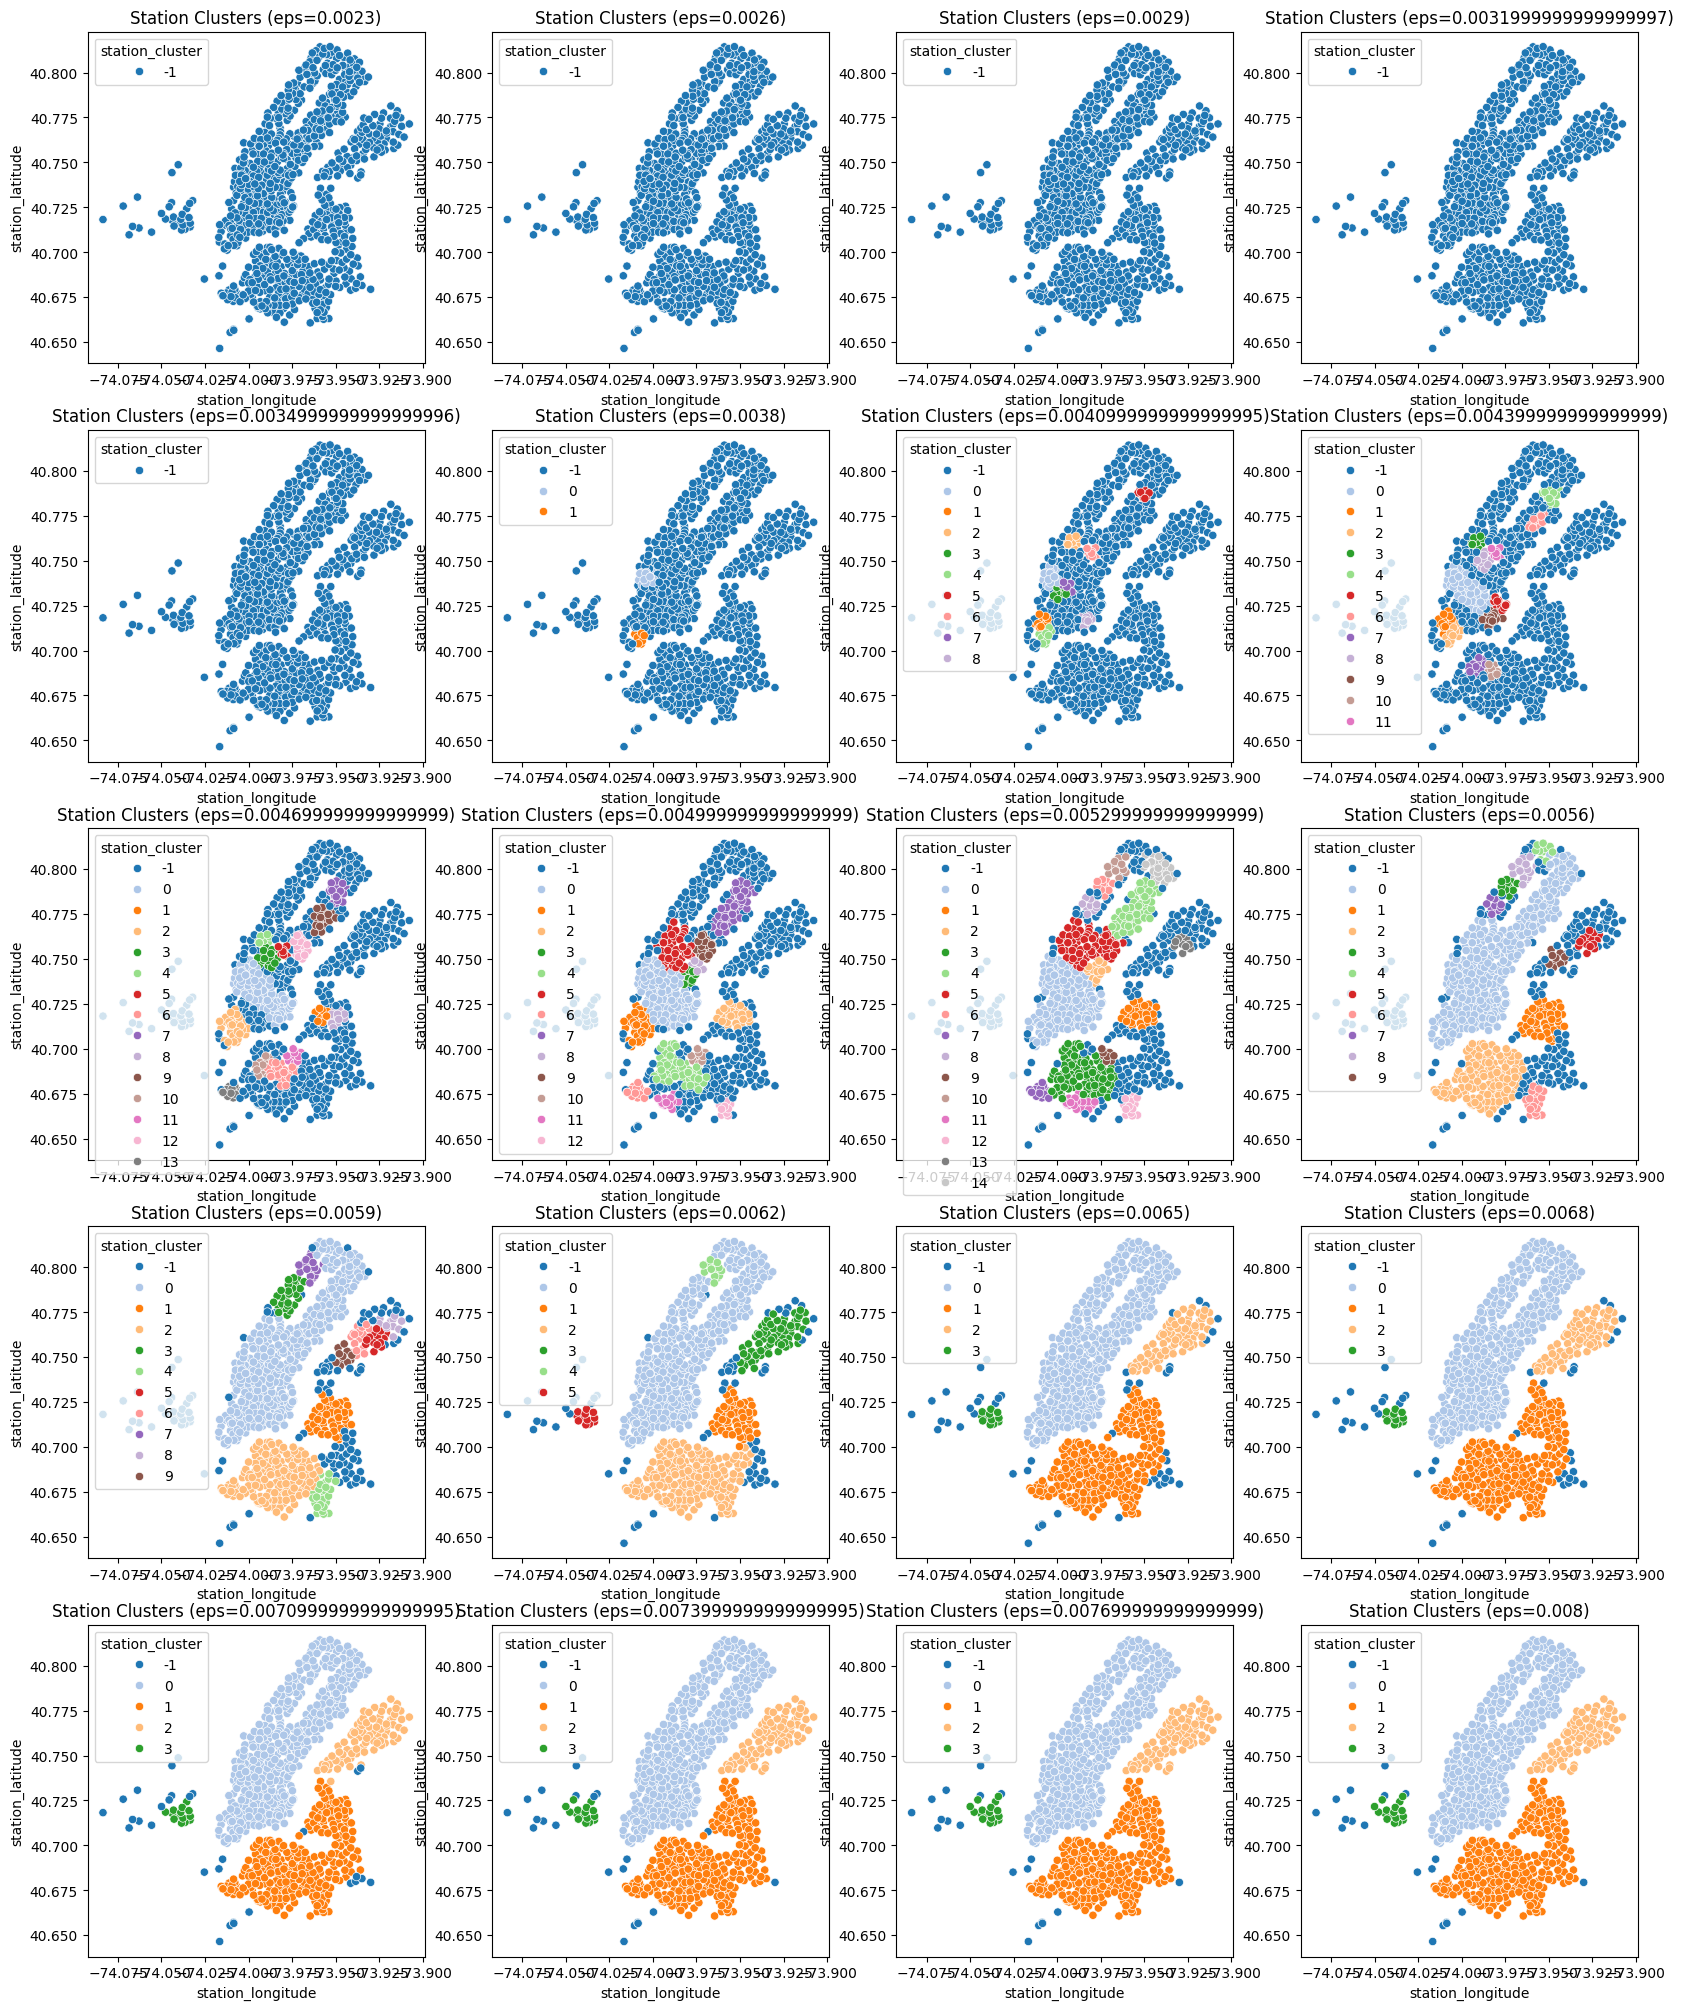

In [14]:
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for i in range(1, 21):
    eps = 0.002+0.0003*i
    dbscan = DBSCAN(eps=eps, min_samples=10)
    dbscan.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = dbscan.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend="full", hue='station_cluster', palette='tab20', ax=ax[(i-1)//4, (i-1)%4])
    ax[(i-1)//4, (i-1)%4].set_title(f'Station Clusters (eps={eps})')

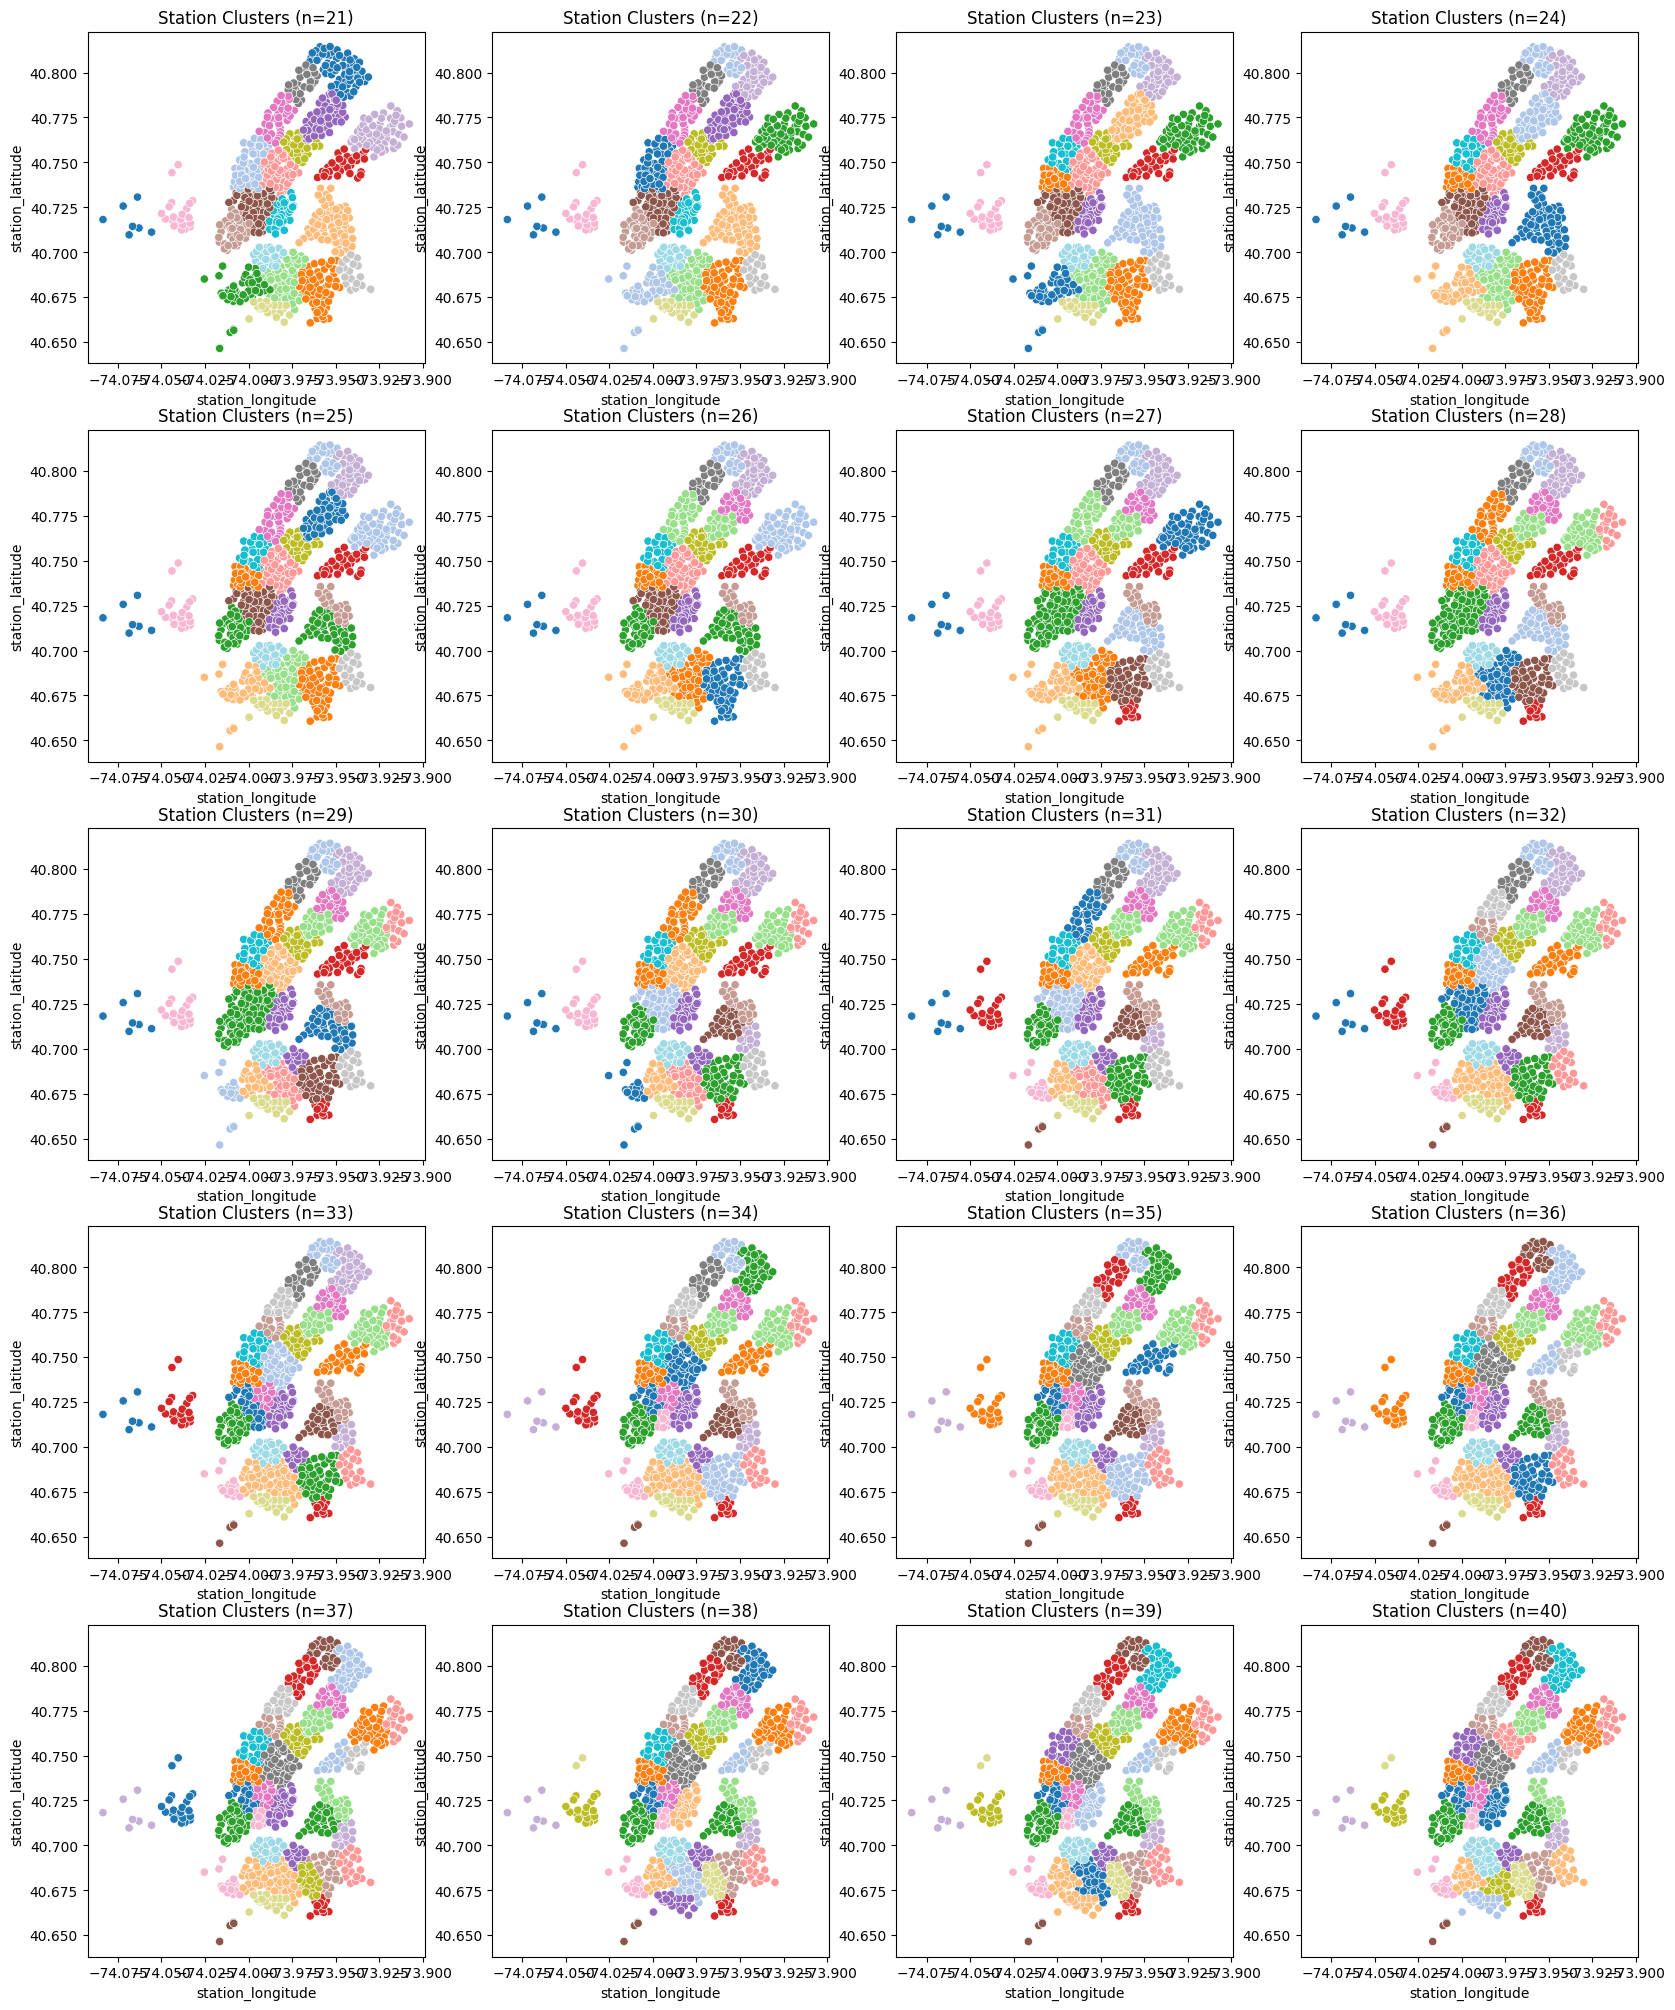

In [15]:
from sklearn.cluster import AgglomerativeClustering

# plot k means for up to 20 clusters
fig, ax = plt.subplots(5, 4, figsize=(20, 25))
for n_clusters in range(1, 21):
    agglo = AgglomerativeClustering(n_clusters=n_clusters+20)
    agglo.fit(stations[['station_latitude', 'station_longitude']])
    stations['station_cluster'] = agglo.labels_
    sns.scatterplot(data=stations, x='station_longitude', y='station_latitude', legend=False, hue='station_cluster', palette='tab20', ax=ax[(n_clusters-1)//4, (n_clusters-1)%4])
    ax[(n_clusters-1)//4, (n_clusters-1)%4].set_title(f'Station Clusters (n={n_clusters+20})')

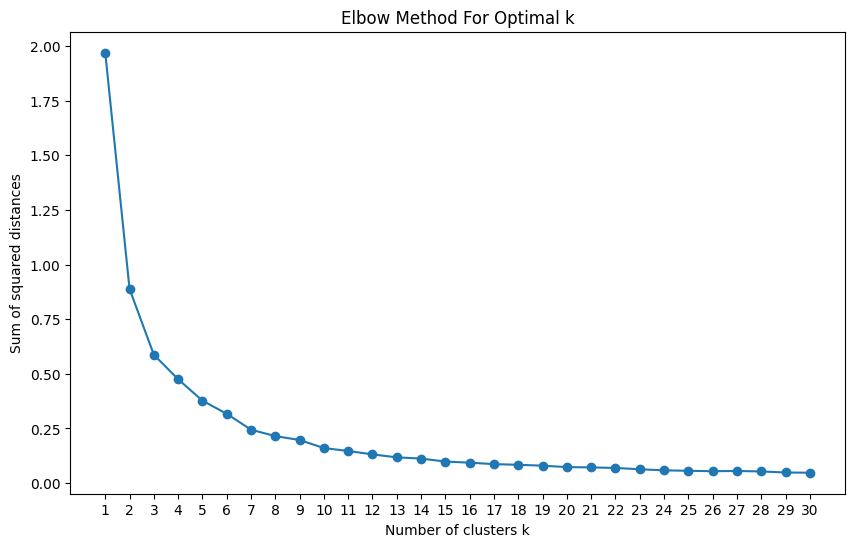

In [16]:
elbow_method(stations[['station_longitude', 'station_latitude']], 30)


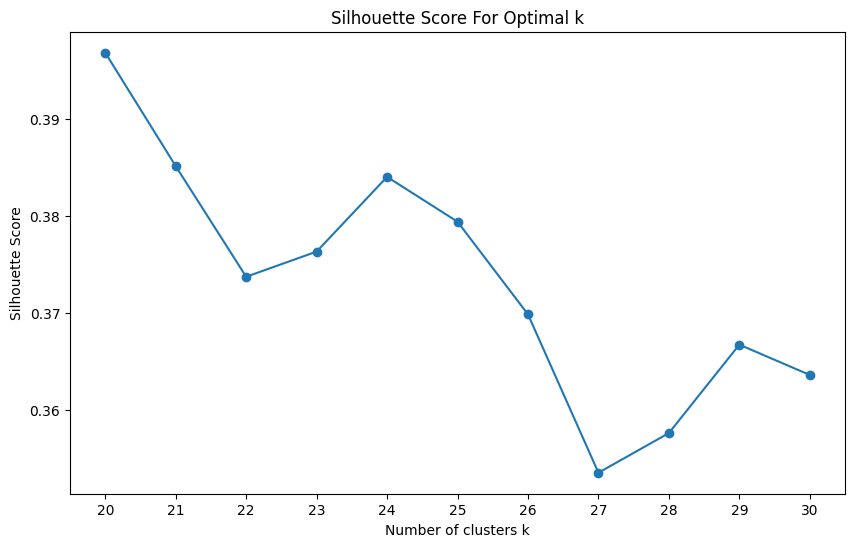

In [17]:
silloute_score_plot(stations[['station_longitude', 'station_latitude']], 30)

In [18]:
kmeans = KMeans(n_clusters=27, random_state=RANDOM_SEED)
kmeans.fit(stations[['station_latitude', 'station_longitude']])
stations['station_cluster'] = kmeans.labels_+1

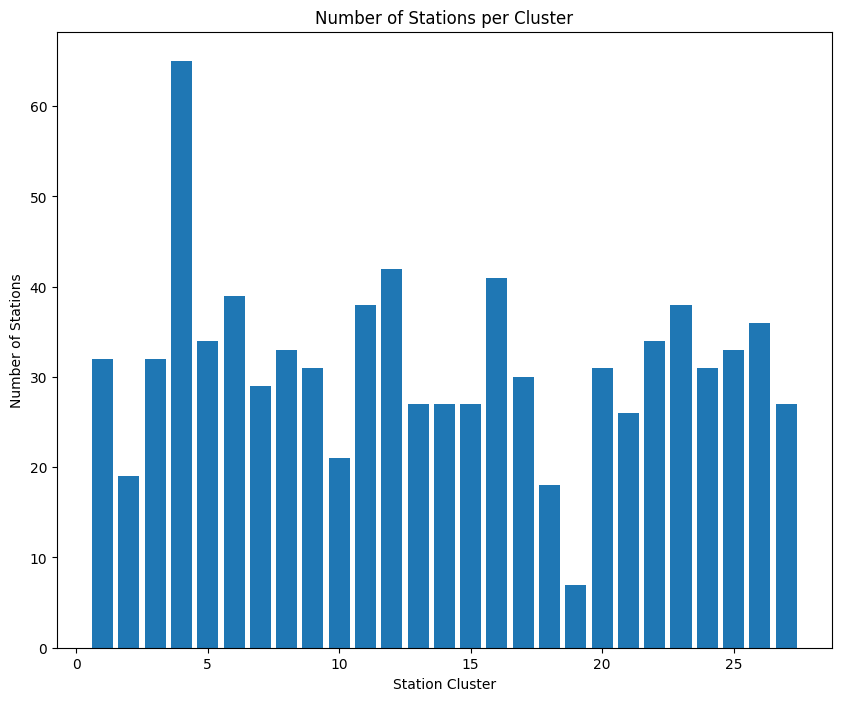

In [19]:
sizes=stations.groupby('station_cluster').size()
fig = plt.figure(figsize=(10, 8))
plt.bar(sizes.index, sizes.values)
plt.xlabel('Station Cluster')
plt.ylabel('Number of Stations')
plt.title('Number of Stations per Cluster')
plt.show()

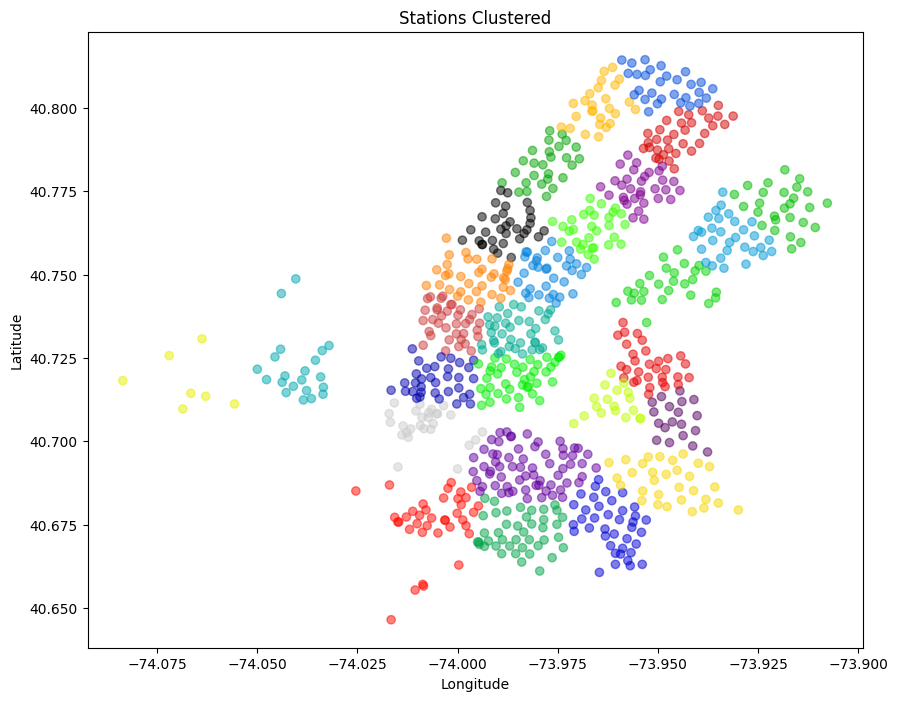

In [20]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(stations['station_longitude'], stations['station_latitude'], c=stations['station_cluster'], cmap='nipy_spectral', alpha=0.5)
plt.title('Stations Clustered')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

We assign the station clusters to the start station ids because this is where the bikes are going to be picked up from 

In [21]:
data["station_cluster"] = data["start_station_id"].map(stations.set_index("station_id")["station_cluster"])

### Check how many bikes on average per hour per cluster

When deciding which clusters to focus on , at least as a starting point, we consider the amount of bikes that are picked up in thast cluster per hour

In [22]:
bikes_per_day = data.groupby(['station_cluster', 'pickup_datetime']).size().reset_index(name='num_rentals')
avg_bikes_per_cluster = bikes_per_day.groupby('station_cluster')['num_rentals'].mean().sort_values(ascending=False).reset_index(name='avg_num_rentals')

In [23]:
cluster = data[data['station_cluster'] == avg_bikes_per_cluster.iloc[0]['station_cluster']]

In [24]:
hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')

In [ ]:
hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])

In [26]:
hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']
hourly_cluster

datetime  num_rentals_pickups  num_rentals_dropoffs
0    2018-01-01 00:00:00                 18.0                  14.0
1    2018-01-01 01:00:00                 30.0                  29.0
2    2018-01-01 02:00:00                 11.0                  16.0
3    2018-01-01 03:00:00                  9.0                   6.0
4    2018-01-01 04:00:00                  2.0                   5.0
...                  ...                  ...                   ...
8723 2018-12-31 19:00:00                 20.0                  21.0
8724 2018-12-31 20:00:00                 28.0                  30.0
8725 2018-12-31 21:00:00                  7.0                   8.0
8726 2018-12-31 22:00:00                  9.0                  11.0
8727 2018-12-31 23:00:00                  1.0                   2.0

[8721 rows x 3 columns]

In [27]:
print(f'size of hourly_cluster: {hourly_cluster.shape}')
def fill_missing_hours(df):
    all_hours = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='h')
    all_hours_df = pd.DataFrame({'datetime': all_hours})
    all_hours_df["datetime"] = pd.to_datetime(all_hours_df["datetime"])
    merged_df = pd.merge(all_hours_df, df, on=['datetime'], how='left')
    merged_df['num_rentals_pickups'] = merged_df['num_rentals_pickups'].fillna(0).astype(int)
    merged_df['num_rentals_dropoffs'] = merged_df['num_rentals_dropoffs'].fillna(0).astype(int)

    return merged_df

hourly_cluster = fill_missing_hours(hourly_cluster)
print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


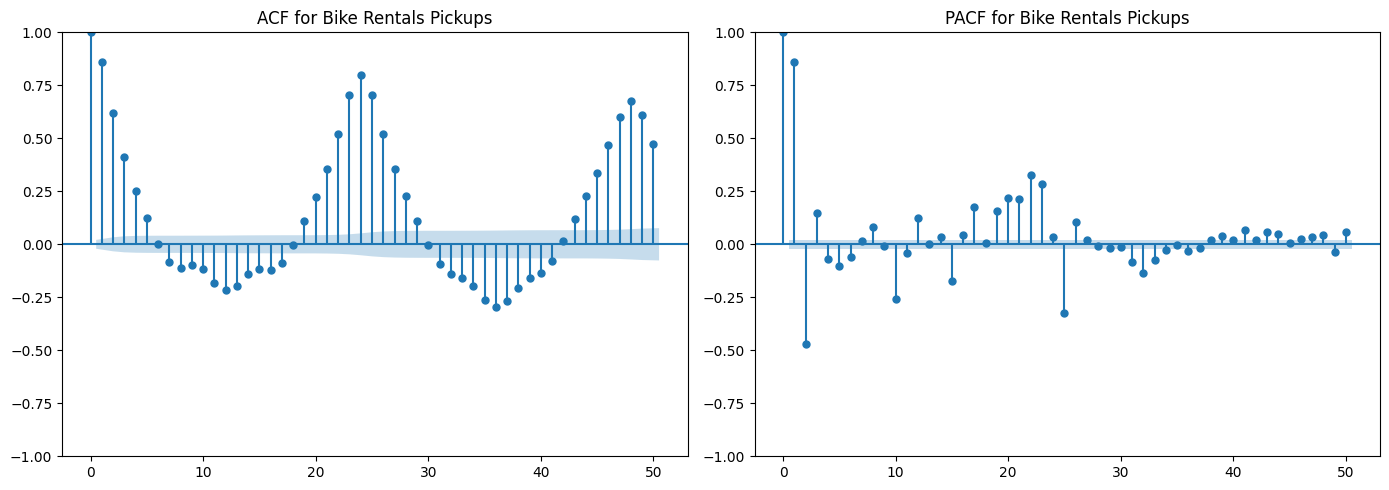

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=50, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f'ACF {title_suffix}')
    
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm') 
    axes[1].set_title(f'PACF {title_suffix}')
    
    plt.tight_layout()
    plt.show()
plot_acf_pacf(hourly_cluster['num_rentals_pickups'], lags=50, title_suffix='for Bike Rentals Pickups')

ACF: decays slowly, crosses significance after lag 5, then rises at multiples of 24 hours.

PACF: significant at lag 0 and 1 positive, lag 2 negative, then essentially small values.

Slow decay in ACF → indicates strong autocorrelation / possible AR component.

PACF spikes at lag 1 → suggests AR(1) term is relevant.

ACF peaks at multiples of 24 hours → indicates daily seasonality (hourly data).

Beyond lag 5, ACF is mostly noise → MA terms may be limited to small lags.

## Train Time Series

In [210]:
##CONSTANTS
END_TRAINING_DATE = pd.to_datetime("2018-11-01 00:00:00")

## Split train- test

In [262]:
train_data = hourly_cluster[hourly_cluster['datetime'] < END_TRAINING_DATE]
test_data = hourly_cluster[hourly_cluster['datetime'] >= END_TRAINING_DATE]
train_data = train_data.set_index('datetime')
test_data  = test_data.set_index('datetime')
train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

train_weather  = weather_cleaned[weather_cleaned['datetime'] < END_TRAINING_DATE]
test_weather   = weather_cleaned[weather_cleaned['datetime'] >= END_TRAINING_DATE]

In [227]:
x_train = train_data.drop(columns=['num_rentals_pickups'])
y_train = train_data['num_rentals_pickups']

x_test = test_data.drop(columns=['num_rentals_pickups'])
y_test = test_data['num_rentals_pickups']

train_data = train_data.asfreq('h')
test_data = test_data.asfreq('h')

In [289]:
def predict_next_24h_recursive(model_fit, test_data, test_weather_exog=None):
    predictions_all = []
    use_exog = test_weather_exog is not None

    for day_start in pd.date_range(start=test_data.index.min(),
                                   end=test_data.index.max() - pd.Timedelta(hours=23),
                                   freq='D'):
        # Exogenous for the next 24 hours
        next_24h_exog = (
            test_weather_exog.loc[day_start : day_start + pd.Timedelta(hours=23)]
            if use_exog else None
        )
        # Forecast 24 hours dynamically using the latest history
        forecast_24h = model_fit.get_forecast(steps=24, exog=next_24h_exog, dynamic=True)
        forecast_24h = forecast_24h.predicted_mean
        forecast_24h = np.clip(forecast_24h, 0, None)

        predictions_all.append(forecast_24h)

    # Combine all forecast windows
    predictions_all = pd.concat(predictions_all)
    return predictions_all



def print_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

def plot_predictions_vs_true(test_data, predicted_column, true_column):
        plt.figure(figsize=(15, 6))
        plt.plot(test_data.index, test_data[true_column], label='Actual', color='blue')
        plt.plot(test_data.index, test_data[predicted_column], label='Predicted', color='orange')
        plt.xlabel('Datetime')
        plt.ylabel('Number of Rentals')
        plt.title('ARIMA Model: Actual vs Predicted Number of Rentals')
        plt.legend()
        plt.show()
    

### We start with a basic arima lagged 24 

In [284]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data['num_rentals_pickups'], order=(24, 0, 0))
model_fit = model.fit()
print(model_fit.summary())


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     num_rentals_pickups   No. Observations:                 7296
Model:                 ARIMA(24, 0, 0)   Log Likelihood              -41330.873
Date:                 Mon, 24 Nov 2025   AIC                          82713.747
Time:                         14:46:06   BIC                          82893.019
Sample:                     01-01-2018   HQIC                         82775.393
                          - 10-31-2018                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        230.6052     25.284      9.121      0.000     181.049     280.161
ar.L1          1.0645      0.009    114.956      0.000       1.046       1.083
ar.L2         -0.4568      0.018    -25.579 

Mean Absolute Error (MAE): 134.5162668274493
Root Mean Squared Error (RMSE): 158.93714078147804


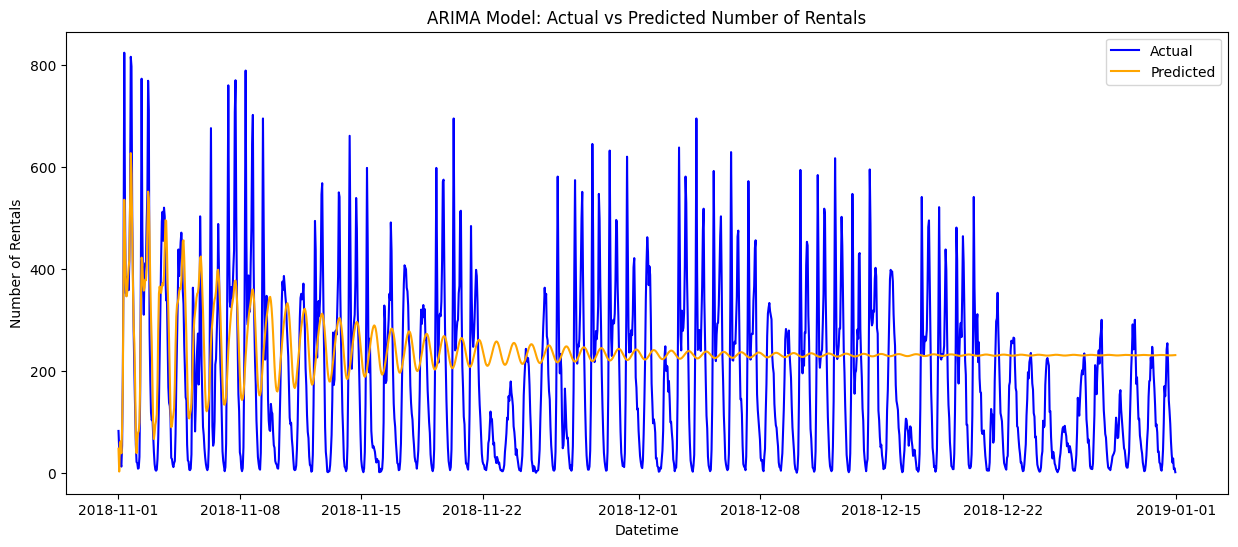

In [291]:
n_steps = len(test_data)
predictions = model_fit.forecast(steps=n_steps)
test_data['predicted_num_rentals'] = predictions.values
print_metrics(test_data['num_rentals_pickups'], test_data['predicted_num_rentals'])
plot_predictions_vs_true(test_data, 'predicted_num_rentals', 'num_rentals_pickups')

With plain ARIMA on hourly bike pickups, the model uses past values and autocorrelations to predict the future. It does not inherently capture daily or weekly cycles, so over a long forecast horizon (like two months), the predictions tend to gradually flatten out toward the average number of pickups in the training data. Essentially, without seasonal components, ARIMA assumes the series will continue around its mean, ignoring repeating patterns or trends, which can make long-term forecasts unrealistic.

### After looking at ACF and PACF we try a SARIMA model

In [292]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 24 hours per day
seasonal_period = 24  

model = SARIMAX(
    train_data['num_rentals_pickups'],
    order=(1,0,4),                # previous hour + MA
    seasonal_order=(1,0,1,seasonal_period), # seasonal component
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit()
print(model_fit.summary())

n_steps = len(test_data)
predictions = model_fit.forecast(steps=n_steps)
test_data['predicted_num_rentals_pickups'] = predictions.values



/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75689D+00    |proj g|=  2.49218D-01


 This problem is unconstrained.



At iterate    5    f=  5.71515D+00    |proj g|=  3.49626D-02

At iterate   10    f=  5.67317D+00    |proj g|=  4.80581D-01

At iterate   15    f=  5.67029D+00    |proj g|=  2.89809D-02

At iterate   20    f=  5.66819D+00    |proj g|=  1.03091D-02

At iterate   25    f=  5.66793D+00    |proj g|=  1.79316D-01

At iterate   30    f=  5.65938D+00    |proj g|=  1.26664D-01

At iterate   35    f=  5.62839D+00    |proj g|=  1.65192D-01

At iterate   40    f=  5.60978D+00    |proj g|=  5.78419D-01

At iterate   45    f=  5.60528D+00    |proj g|=  8.91404D-02


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.60186D+00    |proj g|=  5.54798D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85      1     0     0   5.548D-02   5.602D+00
  F =   5.6018581611746940     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40871.157
Date:                              Mon, 24 Nov 2025   AIC                         

Mean Absolute Error (MAE): 140.29264901532838
Root Mean Squared Error (RMSE): 201.540679864493


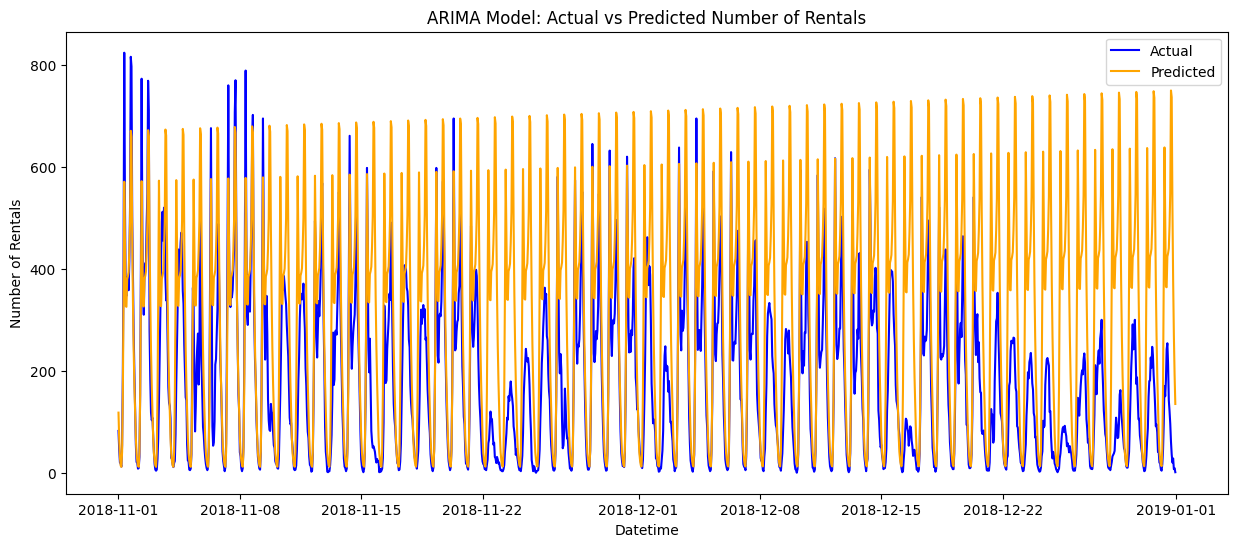

In [295]:
print_metrics(test_data['num_rentals_pickups'], test_data['predicted_num_rentals_pickups'])
plot_predictions_vs_true(test_data, 'predicted_num_rentals_pickups', 'num_rentals_pickups')

### We add exogenous variables

In [296]:
train_exog = train_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
train_exog.index = train_data.index
test_exog = test_weather[['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windspeed','sealevelpressure','visibility']]
test_exog.index = test_data.index

model = SARIMAX(
    train_data['num_rentals_pickups'],
    exog=train_exog,
    order=(1,0,4),                # short-term AR/MA
    seasonal_order=(1,0,1,24),    # daily seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -41317.741
Date:                              Mon, 24 Nov 2025   AIC                          82673.481
Time:                                      14:52:16   BIC                          82804.412
Sample:                                  01-01-2018   HQIC                         82718.513
                                       - 10-31-2018                                         
Covariance Type:                                opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                -8.4713      5.560     -1.524      0.128     -19.368       2.426
f

Mean Absolute Error (MAE): 86.99321396578115
Root Mean Squared Error (RMSE): 133.66859682461873


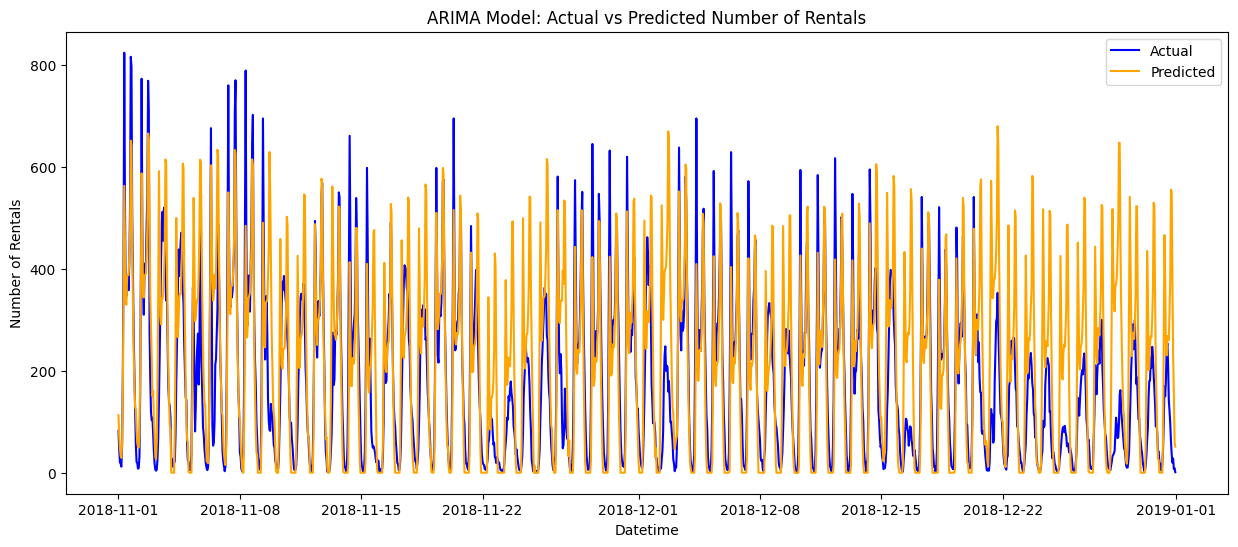

In [297]:
predictions_exog=  predict_next_24h_recursive(model_fit, test_data, test_exog)
test_data['predicted_num_rentals_pickups_exog'] = predictions_exog.values
print_metrics(test_data['num_rentals_pickups'], test_data['predicted_num_rentals_pickups_exog'])
plot_predictions_vs_true(test_data, 'predicted_num_rentals_pickups_exog', 'num_rentals_pickups')

### We keep only the relevant exogenous variables

In [314]:
train_exog = train_weather[['feelslike','precip','visibility']]
train_exog.index = train_data.index
test_exog = test_weather[['feelslike','precip','visibility']]
test_exog.index = test_data.index

model = SARIMAX(
    train_data['num_rentals_pickups'],
    exog=train_exog,
    order=(1,0,4),                # short-term AR/MA
    seasonal_order=(1,0,1,24),    # daily seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  num_rentals_pickups   No. Observations:                 7296
Model:             SARIMAX(1, 0, 4)x(1, 0, [1], 24)   Log Likelihood              -40920.083
Date:                              Mon, 24 Nov 2025   AIC                          81862.166
Time:                                      15:14:46   BIC                          81937.968
Sample:                                  01-01-2018   HQIC                         81888.237
                                       - 10-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feelslike      3.4777      0.422      8.248      0.000       2.651       4.304
precip        -4.89

Mean Absolute Error (MAE): 88.6876112825683
Root Mean Squared Error (RMSE): 140.4296149068613


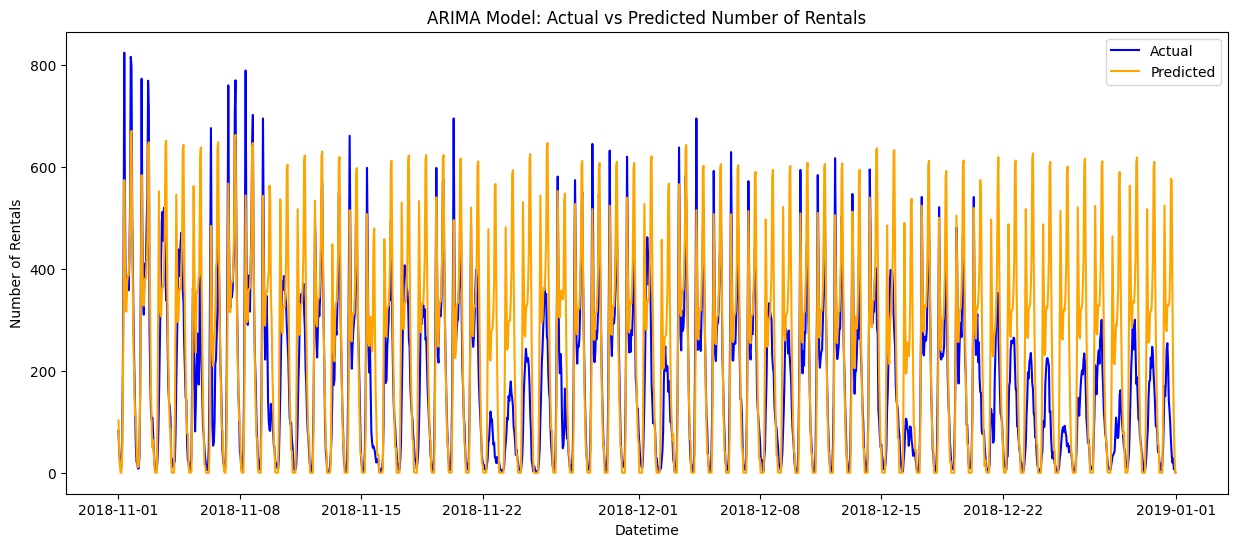

In [299]:
predictions_exog_short=  predict_next_24h_recursive(model_fit, test_data, test_exog)
test_data['predicted_num_rentals_pickups_exog_short'] = predictions_exog_short.values
print_metrics(test_data['num_rentals_pickups'], test_data['predicted_num_rentals_pickups_exog_short'])
plot_predictions_vs_true(test_data, 'predicted_num_rentals_pickups_exog_short', 'num_rentals_pickups')  

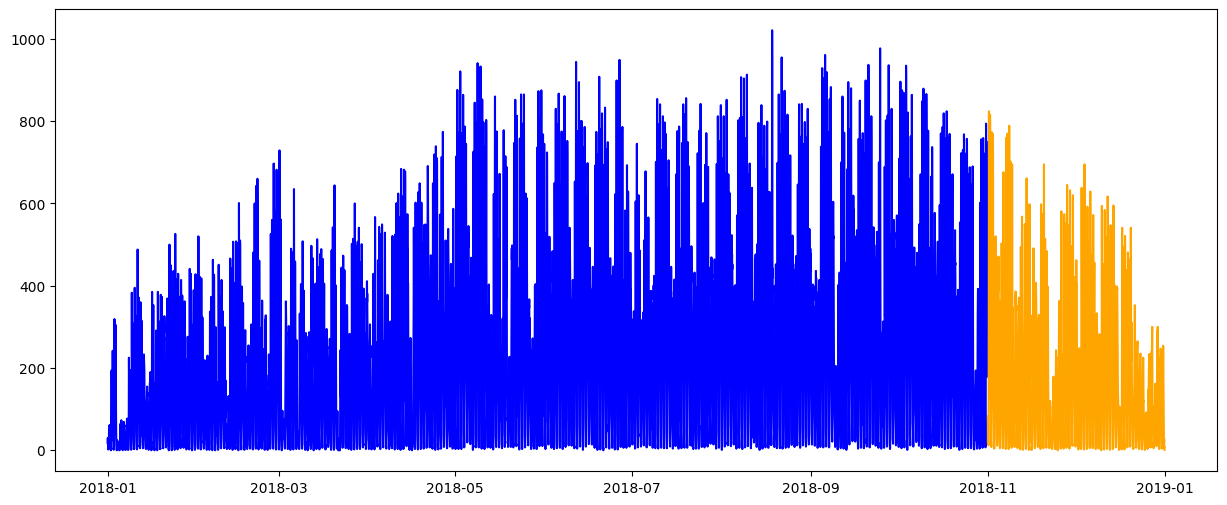

In [300]:
fig= plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['num_rentals_pickups'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['num_rentals_pickups'], label='Fitted', color='orange')

Adding day and hour

In [ ]:
train_exog = train_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
train_exog = pd.get_dummies(train_exog, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
train_exog.index = train_data.index
test_exog = test_weather[['feelslike','precip','visibility', 'day_of_week', 'hour_of_day']]
test_exog = pd.get_dummies(test_exog, columns=['hour_of_day', 'day_of_week'], drop_first=True).astype(float)
test_exog.index = test_data.index

model = SARIMAX(
    train_data['num_rentals_pickups'],
    exog=train_exog,
    order=(1,0,4),                # short-term AR/MA
    seasonal_order=(1,0,1,24),    # daily seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

Mean Absolute Error (MAE): 71.63031397769144
Root Mean Squared Error (RMSE): 111.42020412634146


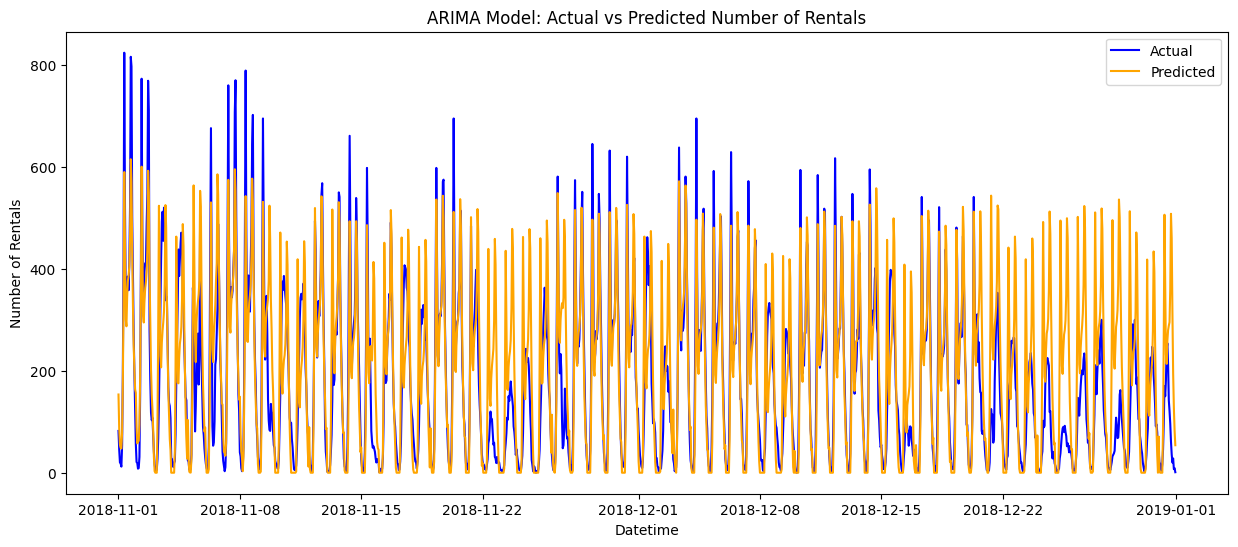

In [307]:
predictions_sarimax_dh=  predict_next_24h_recursive(model_fit, test_data, test_exog)
test_data['predicted_num_rentals_pickups_sarimax_dh'] = predictions_sarimax_dh.values
print_metrics(test_data['num_rentals_pickups'], test_data['predicted_num_rentals_pickups_sarimax_dh'])
plot_predictions_vs_true(test_data, 'predicted_num_rentals_pickups_sarimax_dh', 'num_rentals_pickups')

# NN

In [308]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
# --- Parameters ---
n_lags = 168        # previous week of hourly data
forecast_horizon = 24  # next 24 hours

# --- Create lag features ---
df = train_data[['num_rentals_pickups']].copy()

lags = {f'pickup_lag_{lag}': df['num_rentals_pickups'].shift(lag) for lag in range(1, n_lags+1)}
lags_df = pd.DataFrame(lags, index=df.index)

df = pd.concat([df, lags_df], axis=1)

exog_features = ['day_of_week','hour_of_day','feelslike', 'precip', 'visibility']
df[exog_features] = weather_cleaned.set_index('datetime')[exog_features].loc[df.index]

# --- Create multi-step target ---
for step in range(1, forecast_horizon + 1):
    df[f'target_t+{step}'] = df['num_rentals_pickups'].shift(-step)

# --- Drop rows with NaNs due to lags or forward targets ---
all_columns = [f'pickup_lag_{lag}' for lag in range(1, n_lags + 1)] + \
              exog_features + \
              [f'target_t+{step}' for step in range(1, forecast_horizon + 1)]
df = df.dropna(subset=all_columns)

# --- Define features X and target y ---
X = df[[f'pickup_lag_{lag}' for lag in range(1, n_lags + 1)] + exog_features].values
y = df[[f'target_t+{step}' for step in range(1, forecast_horizon + 1)]].values

# --- Split into train/test (time series, no shuffle) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [310]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon) 
])
model.compile(optimizer='adam', loss='mse')

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [311]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49195.4141 - val_loss: 33637.8359
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 18458.1992 - val_loss: 21285.0664
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 15448.0596 - val_loss: 18127.2812
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 14267.8281 - val_loss: 16809.3711
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 13625.1250 - val_loss: 15976.6064
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 12973.6621 - val_loss: 15312.5361
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 12660.5664 - val_loss: 14539.9385
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 12071.3389 - val_loss: 13782.3037
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 11668.9258 - val_loss: 13211.0469
Epoch 10/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 11319.0361 - val_loss: 12715.0322
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred = np.clip(y_pred, 0, None)

mae_per_hour = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse_per_hour = root_mean_squared_error(y_test, y_pred, multioutput='raw_values')

print("Overall MAE:", np.mean(mae_per_hour))
print("Overall RMSE:", np.mean(rmse_per_hour))


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
Overall MAE: 62.76299454386793
Overall RMSE: 96.57660824262496
